In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from lm_eval.filters.extraction import RegexFilter
from gsm8k_eval_passk import norm, top_nonblank

In [2]:
def evaluate_json_file(json_path, source="torchtune", max_k=128):
    """
    Evaluate a single JSON file and return majority voted accuracy for k=1 to max_k
    """
    if source == "torchtune": 
        with open(json_path, "r") as f:
            data = json.load(f)
        samples = data["samples"]["gsm8k_fewshot_128"][:1313] #consider the only unique set
    elif source == "lm_eval":
        samples = []
        with open(json_path, 'r', encoding='utf-8') as file:
            for line in file:
                json_obj = json.loads(line.strip())
                samples.append({"resps":json_obj["resps"],"target":json_obj["target"]})
    
    ks = list(range(1, max_k + 1))
    rf = RegexFilter(regex_pattern=r"(?<=[Tt]he answer is )[^.\\]+")
    maj_correct = {k: 0 for k in ks}
    n_q = 0

    for s in samples:
        gt = norm(s["target"])
        resps = s["resps"][0]
        # extract answers once, then slice for ks
        extracted = rf.apply([resps], [{}])[0]
        extracted_norm = [norm(a) for a in extracted]

        # per-k accuracies
        for k in ks:
            sub = extracted_norm[:min(k, len(extracted_norm))]
            if not sub:
                continue
            c = Counter(sub)
            maj_ans, _ = top_nonblank(c)
            maj_correct[k] += int(maj_ans == gt)

        n_q += 1
    
    # Calculate accuracy for each k
    maj_acc = {k: (maj_correct[k] / n_q if n_q else 0.0) for k in ks}
    return maj_acc, n_q

def calculate_confidence_bin_accuracies(json_paths, source="torchtune", max_k=128):
    """
    Compute majority-voted accuracy curves per confidence bin without plotting.

    Args:
        json_paths: List of 10 JSON file paths corresponding to confidence bins
        source: Source format ("torchtune" or "lm_eval")
        max_k: Maximum number of samples to evaluate (default 128)

    Returns:
        A dict with keys:
            - "k_values": list of k from 1..max_k
            - "bins": list of dicts with keys {"label", "accuracies", "n_q", "path"}
    """
    bin_labels = [
        "(0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
        "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]"
    ]

    k_values = list(range(1, max_k + 1))
    results = {"k_values": k_values, "bins": []}

    for i, json_path in enumerate(json_paths):
        print(f"Processing confidence bin {i+1}/10: {bin_labels[i]}")
        try:
            maj_acc, n_q = evaluate_json_file(json_path, source, max_k)
            accuracies = [maj_acc[k] for k in k_values]
            results["bins"].append({
                "label": bin_labels[i],
                "accuracies": accuracies,
                "n_q": n_q,
                "path": json_path,
            })
        except Exception as e:
            print(f"Error processing {json_path}: {e}")
            results["bins"].append({
                "label": bin_labels[i],
                "accuracies": [0.0 for _ in k_values],
                "n_q": 0,
                "path": json_path,
                "error": str(e),
            })

    return results

def plot_confidence_bins(json_paths, source="torchtune", max_k=128):
    """
    Plot majority voted accuracy vs number of samples for 10 confidence bins
    
    Args:
        json_paths: List of 10 JSON file paths corresponding to confidence bins
        source: Source format ("torchtune" or "lm_eval")
        max_k: Maximum number of samples to evaluate (default 128)
    """
    bin_data = calculate_confidence_bin_accuracies(json_paths, source, max_k)
    plot_confidence_bins_from_data(bin_data, max_k=max_k)

def plot_confidence_bins_from_data(bin_data, max_k=128):
    """
    Plot majority-voted accuracy vs number of samples using precomputed data.

    Args:
        bin_data: Dict returned by calculate_confidence_bin_accuracies
        max_k: Maximum number of samples to show on x-axis
    """
    # Colors for each line
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    plt.figure(figsize=(8, 5))

    k_values = bin_data.get("k_values", list(range(1, max_k + 1)))
    plot_k_values = [k for k in k_values if k >= 2]

    for i, bin_entry in enumerate(bin_data.get("bins", [])):
        label = bin_entry.get("label", f"bin_{i}")
        accuracies = bin_entry.get("accuracies", [])
        n_q = bin_entry.get("n_q", 0)

        # slice accuracies to align with plot_k_values (k >= 2)
        k_len = len(plot_k_values)
        acc_slice = accuracies[1:k_len+1]
        plt.plot(
            plot_k_values,
            acc_slice,
            color=colors[i % len(colors)],
            label=f"{label}",
            linewidth=2,
        )

    # x-axis: log scale with specific ticks
    plt.xscale('log')
    xticks = [2, 4, 8, 16, 32, 64, 128]
    plt.xticks(xticks, xticks)
    # disable minor ticks to avoid tiny tick marks between powers of two
    plt.minorticks_off()

    plt.xlabel('Number of Samples', fontsize=12)
    plt.ylabel('Majority Voted Accuracy', fontsize=12)

    # legend: inside, reverse order (largest bin first)
    handles, labels = plt.gca().get_legend_handles_labels()
    plt.legend(handles[::-1], labels[::-1], loc='lower right', framealpha=0.9, title='Confidence bin')

    # remove grid lines per request
    # plt.grid(True, which='both', alpha=0.3)
    plt.xlim(2, max_k)
    plt.ylim(0.6, 0.75)

    plt.tight_layout()

    plt.savefig('confidence_bin_plot.png',
                dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
def evaluate_json_file_with_uniques(json_path, source="torchtune", max_k=128):
    """
    Evaluate a single JSON file and return:
      - majority voted accuracy for k=1..max_k
      - average number of unique answers for k=1..max_k
      - number of questions (n_q)
    """
    if source == "torchtune":
        with open(json_path, "r") as f:
            data = json.load(f)
        samples = data["samples"]["gsm8k_fewshot_128"][:1313]
    elif source == "lm_eval":
        samples = []
        with open(json_path, 'r', encoding='utf-8') as file:
            for line in file:
                json_obj = json.loads(line.strip())
                samples.append({"resps": json_obj["resps"], "target": json_obj["target"]})

    ks = list(range(1, max_k + 1))
    rf = RegexFilter(regex_pattern=r"(?<=[Tt]he answer is )[^.\\]+")
    maj_correct = {k: 0 for k in ks}
    uniq_counts_sum = {k: 0 for k in ks}
    n_q = 0

    for s in samples:
        gt = norm(s["target"])
        resps = s["resps"][0]
        extracted = rf.apply([resps], [{}])[0]
        extracted_norm = [norm(a) for a in extracted]

        for k in ks:
            sub = extracted_norm[:min(k, len(extracted_norm))]
            if sub:
                c = Counter(sub)
                maj_ans, _ = top_nonblank(c)
                maj_correct[k] += int(maj_ans == gt)
                uniq_counts_sum[k] += len(c)
            else:
                uniq_counts_sum[k] += 0

        n_q += 1

    maj_acc = {k: (maj_correct[k] / n_q if n_q else 0.0) for k in ks}
    avg_uniq_counts = {k: (uniq_counts_sum[k] / n_q if n_q else 0.0) for k in ks}
    return maj_acc, avg_uniq_counts, n_q


def calculate_confidence_bin_stats(json_paths, source="torchtune", max_k=128):
    """
    Compute per-bin majority-voted accuracy and average unique answer counts for k=1..max_k.

    Returns a dict with keys:
        - "k_values": list of k from 1..max_k
        - "bins": list of dicts with keys {"label", "accuracies", "uniq_counts", "n_q", "path"}
    """
    bin_labels = [
        "(0,0.1]", "(0.1,0.2]", "(0.2,0.3]", "(0.3,0.4]", "(0.4,0.5]",
        "(0.5,0.6]", "(0.6,0.7]", "(0.7,0.8]", "(0.8,0.9]", "(0.9,1.0]"
    ]

    k_values = list(range(1, max_k + 1))
    results = {"k_values": k_values, "bins": []}

    for i, json_path in enumerate(json_paths):
        print(f"Processing confidence bin {i+1}/10: {bin_labels[i]}")
        try:
            maj_acc, avg_uniq_counts, n_q = evaluate_json_file_with_uniques(json_path, source, max_k)
            accuracies = [maj_acc[k] for k in k_values]
            uniq_counts = [avg_uniq_counts[k] for k in k_values]
            results["bins"].append({
                "label": bin_labels[i],
                "accuracies": accuracies,
                "uniq_counts": uniq_counts,
                "n_q": n_q,
                "path": json_path,
            })
        except Exception as e:
            print(f"Error processing {json_path}: {e}")
            results["bins"].append({
                "label": bin_labels[i],
                "accuracies": [0.0 for _ in k_values],
                "uniq_counts": [0.0 for _ in k_values],
                "n_q": 0,
                "path": json_path,
                "error": str(e),
            })

    return results


def plot_confidence_bins_with_uniques(bin_data, max_k=128):
    """
    DEPRECATED: Use plot_confidence_bins_two_plots instead.
    """
    return plot_confidence_bins_two_plots(bin_data, max_k=max_k)


def plot_confidence_bins_two_plots(bin_data, max_k=128):
    """
    Plot two subplots: left shows accuracy curves; right shows avg unique answers curves.
    Both subplots share a single legend for the confidence bins.
    """
    colors = plt.cm.tab10(np.linspace(0, 1, 10))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), sharex=True)

    k_values = bin_data.get("k_values", list(range(1, max_k + 1)))
    plot_k_values = [k for k in k_values if k >= 2]

    # Accuracy on ax1
    for i, bin_entry in enumerate(bin_data.get("bins", [])):
        label = bin_entry.get("label", f"bin_{i}")
        accuracies = bin_entry.get("accuracies", [])
        k_len = len(plot_k_values)
        acc_slice = accuracies[1:k_len+1]
        ax1.plot(
            plot_k_values,
            acc_slice,
            color=colors[i % len(colors)],
            label=f"{label}",
            linewidth=2,
        )

    ax1.set_xscale('log')
    ax1.minorticks_off()
    ax1.set_xlabel('Number of Samples', fontsize=13)
    ax1.set_ylabel('Majority Voted Accuracy', fontsize=13)
    ax1.set_xlim(2, max_k)
    ax1.set_ylim(0.65, 0.75)

    # Avg unique answers on ax2 (dotted), no legend labels to avoid duplicates
    for i, bin_entry in enumerate(bin_data.get("bins", [])):
        uniq_counts = bin_entry.get("uniq_counts", [])
        k_len = len(plot_k_values)
        uniq_slice = uniq_counts[1:k_len+1]
        ax2.plot(
            plot_k_values,
            uniq_slice,
            color=colors[i % len(colors)],
            linewidth=2,
        )

    ax2.set_xscale('log')
    ax2.minorticks_off()
    ax2.set_xlabel('Number of Samples', fontsize=13)
    ax2.set_ylabel('Avg number of unique answers', fontsize=13)
    ax2.set_xlim(2, max_k)

    # x ticks
    xticks = [2, 4, 8, 16, 32, 64, 128]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(xticks)
    ax2.set_xticks(xticks)
    ax2.set_xticklabels(xticks)

    # Shared legend to the right in a single column (tighter spacing)
    handles, labels = ax1.get_legend_handles_labels()
    # reverse to match prior ordering
    legend = fig.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(0.885, 0.5), borderaxespad=0.0, framealpha=0.9, ncol=1, title='Confidence bin', fontsize=12, title_fontsize=12)

    # Adjust layout to make room for external legend (minimal gap)
    fig.subplots_adjust(right=0.87, wspace=0.15)

    fig.savefig('confidence_bin_plot_two_panels.pdf',
                dpi=300, bbox_inches='tight')
    plt.show()


In [4]:
json_paths = [
    ]
    
bin_data = calculate_confidence_bin_stats(json_paths[::-1], source="torchtune", max_k=128)

Processing confidence bin 1/10: (0,0.1]
Processing confidence bin 2/10: (0.1,0.2]
Processing confidence bin 3/10: (0.2,0.3]
Processing confidence bin 4/10: (0.3,0.4]
Processing confidence bin 5/10: (0.4,0.5]
Processing confidence bin 6/10: (0.5,0.6]
Processing confidence bin 7/10: (0.6,0.7]
Processing confidence bin 8/10: (0.7,0.8]
Processing confidence bin 9/10: (0.8,0.9]
Processing confidence bin 10/10: (0.9,1.0]


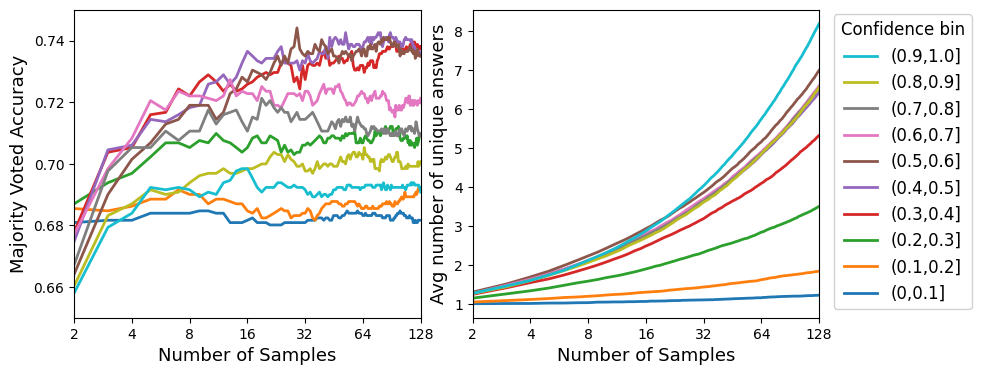

In [21]:
plot_confidence_bins_with_uniques(bin_data, max_k=128)

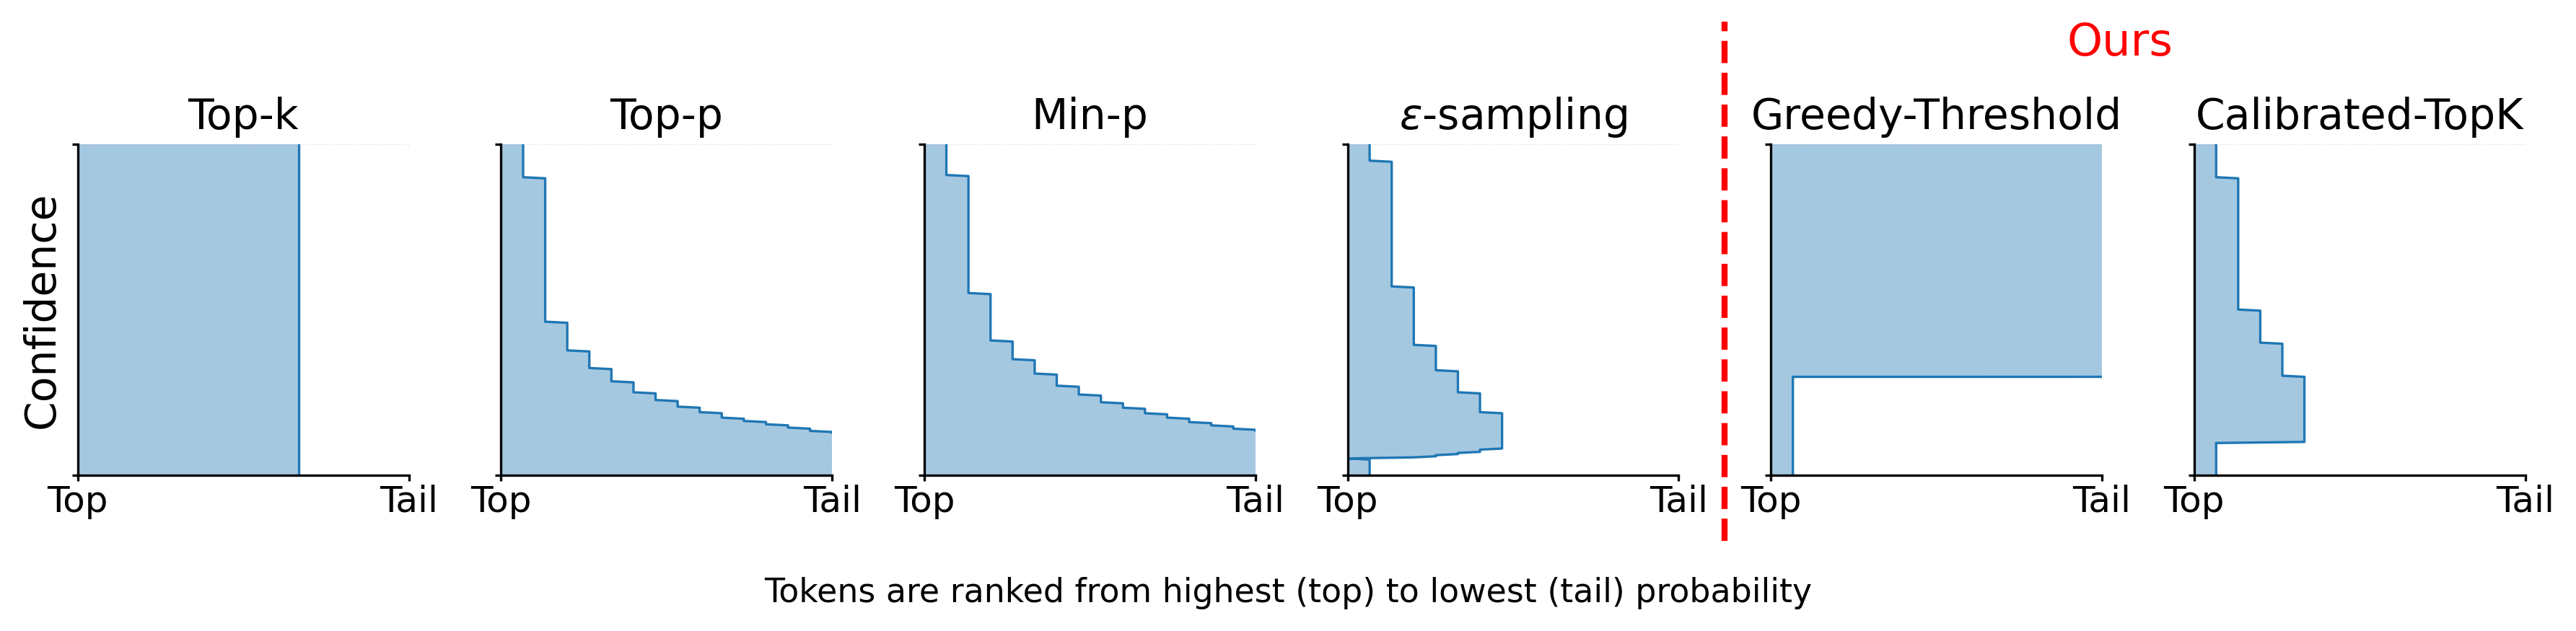

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np

class CalibratedTopK:
    """
    Bin by p_max into 10 confidence bins, average probs by rank in each bin,
    then choose a single rank threshold per bin: the largest rank r with
    avg_prob_at_rank[r-1] >= p.
    """
    def __init__(self, num_bins: int = 10, V: int | None = None, bin_edges: np.ndarray | None = None):
        self.num_bins = num_bins
        self.V = V
        self.bin_edges = np.linspace(0.0, 1.0, num_bins + 1) if bin_edges is None else np.asarray(bin_edges)
        self.sum_probs = None   # shape [B, V]
        self.counts = None      # shape [B]
        self.avg_by_bin = None  # shape [B, V]

    def _ensure_shapes(self, V: int):
        if self.V is None:
            self.V = V
        if self.sum_probs is None:
            self.sum_probs = np.zeros((self.num_bins, self.V), dtype=float)
            self.counts = np.zeros(self.num_bins, dtype=int)

    def fit(self, probs_list: list[np.ndarray]):
        """
        probs_list: iterable of 1D arrays (sorted desc), one per simulated sample.
        """
        for p in probs_list:
            V = len(p)
            self._ensure_shapes(V)
            # enforce same V (pad/truncate if needed)
            if V != self.V:
                if V < self.V:
                    q = np.zeros(self.V, float); q[:V] = p
                else:
                    q = p[:self.V]
            else:
                q = p
            pmax = float(q[0])
            # bin index 0..num_bins-1
            b = np.digitize(pmax, self.bin_edges, right=False) - 1
            b = max(0, min(self.num_bins - 1, b))
            self.sum_probs[b] += q
            self.counts[b] += 1

        # averages (zeros if bin empty)
        self.avg_by_bin = np.zeros_like(self.sum_probs)
        nz = self.counts > 0
        self.avg_by_bin[nz] = self.sum_probs[nz] / self.counts[nz, None]
        return self

    def keep_count(self, probs: np.ndarray, p: float = 0.1) -> int:
        """
        For the bin of this sample's p_max, return the calibrated rank threshold.
        """
        assert self.avg_by_bin is not None, "Call fit() first with your simulated logits."
        pmax = float(probs[0])
        b = np.digitize(pmax, self.bin_edges, right=False) - 1
        b = max(0, min(self.num_bins - 1, b))
        if self.counts[b] == 0:
            return 1  # fallback if no data in bin
        avg = self.avg_by_bin[b]  # shape [V]
        idx = np.where(avg >= p)[0]
        return int(idx.max() + 1) if idx.size > 0 else 1


def make_keep_count_calibrated_topk(probs_list: list[np.ndarray], num_bins: int = 10):
    """
    Convenience factory: fit once, get a drop-in function keep_count_calibrated_topk(probs, p)
    suitable for your sampler pipeline.
    """
    cal = CalibratedTopK(num_bins=num_bins).fit(probs_list)
    def keep_count_calibrated_topk(probs: np.ndarray, p: float = 0.1) -> int:
        return cal.keep_count(probs, p=p)
    return keep_count_calibrated_topk

# ---------------------- Simulation ----------------------
V = 15  # nominal vocab size
R = V
y_plot = np.linspace(0.0, 1.0, 301)
Y_EPS = 1e-13

def s_of_y(y, s_min=0.3, s_span=3.0):
    return s_min + s_span * y

def simulate_probs_for_y(y, V=500):
    y = float(np.clip(y, 1.0/V + 1e-9, 1.0 - 1e-9))  # keep feasible and stable

    # Base sharpness that increases with y (peaky at high y)
    s_base = 0.3 + 3.0 * y

    # Finite geometric tail sum S(s) over ranks 2..V (weights e^{-s * j}, j=0..V-2)
    def tail_sum(s):
        q = np.exp(-s)
        # sum_{j=0}^{V-2} q^j
        return (1.0 - q**(V-1)) / (1.0 - q + 1e-18)

    need = (1.0 - y) / y          # minimal sum so that A <= y
    S_base = tail_sum(s_base)

    # If base tail can't hold the mass under the cap y, flatten (reduce s) via bisection
    if S_base < need:
        lo, hi = 1e-6, s_base
        for _ in range(60):
            mid = 0.5 * (lo + hi)
            if tail_sum(mid) >= need:
                lo = mid
            else:
                hi = mid
        s = lo
    else:
        s = s_base

    # Build probabilities: p1=y, tail decays with s and sums to (1-y), with each tail term <= y
    ranks = np.arange(V - 1)
    w = np.exp(-s * ranks)
    A = (1.0 - y) / w.sum()
    tail = A * w
    # By construction A <= y (equality only when S == need); keep it strictly below:
    tail = np.minimum(tail, np.nextafter(y, 0.0))

    p = np.empty(V, dtype=float)
    p[0] = y
    p[1:] = tail
    # Already nonincreasing, but sort just in case of numerical ties
    return np.sort(p)[::-1]


# ---------------------- Samplers ----------------------
def keep_count_topk(probs, k=10):
    return min(k, probs.size)

def keep_count_topp(probs, p_threshold=0.9):
    csum = np.cumsum(probs)
    idx = int(np.searchsorted(csum, p_threshold, side="left"))
    return min(idx + 1, probs.size)

def keep_count_minp_rel(probs, min_p_rel=0.05):
    if probs.size == 0:
        return 0
    p_max = float(probs[0])
    return int(np.sum(probs > (min_p_rel * p_max)))

def keep_count_epsilon_abs(probs, epsilon_abs=1e-3):
    p_max = float(probs[0])
    if probs.size == 0:
        return 0
    return int(np.sum(probs > epsilon_abs)) if p_max >= epsilon_abs else 1

#def keep_count_calibrated_topk(probs, p=0.1):
#    p_max = float(probs[0])
#    return int(np.sum(probs >= p)) if p_max >= p else 1

def keep_count_greedy_threshold(probs, p=0.3):
    if probs.size == 0:
        return 0
    p_max = float(probs[0])
    return probs.size if p_max >= p else 1

# ---------------------- Compute boundaries ----------------------
def boundary_from_sampler(keep_fn, **kwargs):
    kept_fracs = []
    for y in y_plot:
        probs = simulate_probs_for_y(y)
        k = keep_fn(probs, **kwargs)
        kept_fracs.append(k / R)
    return np.array(kept_fracs)

cal_set = [simulate_probs_for_y(y) for y in y_plot]  # sorted descending

# Create the calibrated function
keep_count_calibrated_topk = make_keep_count_calibrated_topk(cal_set, num_bins=10)

# Then use it in boundary_from_sampler(...)
frac_ctopk = boundary_from_sampler(keep_count_calibrated_topk, p=0.07)

frac_topk   = boundary_from_sampler(keep_fn=keep_count_topk, k=10)
frac_topp   = boundary_from_sampler(keep_fn=keep_count_topp, p_threshold=0.9)
frac_minp   = boundary_from_sampler(keep_fn=keep_count_minp_rel, min_p_rel=0.1)
frac_eps    = boundary_from_sampler(keep_fn=keep_count_epsilon_abs, epsilon_abs=0.05)
frac_gthres = boundary_from_sampler(keep_fn=keep_count_greedy_threshold, p=0.3)
#frac_ctopk  = boundary_from_sampler(keep_fn=keep_count_calibrated_topk, p=0.05)

# ---------------------- Plot panels ----------------------
titles = ["Top-k", "Top-p", "Min-p", "$\epsilon$-sampling", "Greedy-Threshold", "Calibrated-TopK"]
fracs = [frac_topk, frac_topp, frac_minp, frac_eps, frac_gthres, frac_ctopk]

fig, axes = plt.subplots(1, 6, figsize=(12, 2.4), sharex=True, sharey=True, dpi=300)
plt.subplots_adjust(wspace=0.0)  # No gaps between panels

for i, ax in enumerate(axes):
    ax.fill_betweenx(y_plot, 0, fracs[i], alpha=0.4)
    ax.plot(fracs[i], y_plot, linewidth=0.8)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis='both', which='both', labelsize=7, length=2, pad=1)
    ax.set_xticks([0, 1], labels=["Top", "Tail"] if i in (0, 5) else ["", ""], fontsize=12)
    ax.set_yticks([0, 1])
    if i != 0:
        ax.set_yticklabels([])
    ax.grid(True, linestyle=":", linewidth=0.3, alpha=0.5)
    ax.set_title(titles[i], fontsize=14, pad=5)

axes[0].set_ylabel("Confidence", fontsize=14, labelpad=2)
fig.text(0.5, -0.02, "Tokens are ranked from highest (top) to lowest (tail) probability", ha="center", va="top", fontsize=11)

#lt.axvline(x=0.1, ymin=0, ymax=1, color='red', linewidth=2.0, linestyle='--')

# Add "Ours" text to the right of the line, centered vertically, rotated 90 degrees
fig.text(0.8, 1.05, "Ours", fontsize=15, va="top", ha="left", color='red')

plt.tight_layout()

fig.canvas.draw()
x_right_eps = axes[3].get_position().x1   # right edge of Epsilon panel
x_left_gth  = axes[4].get_position().x0   # left edge of Greedy panel
x_div = 0.5 * (x_right_eps + x_left_gth)  # midpoint between them

# vertical span covering the panels
y0 = 0.05
y1 = 1.05

# draw the vertical divider in figure coordinates
line = mlines.Line2D([x_div, x_div], [y0, y1],
                     transform=fig.transFigure,
                     color='red', lw=2.0, ls='--')
fig.add_artist(line)
fig.savefig("/figure0.png", bbox_inches='tight')

plt.show()
